<p>

### CHALLENGE 1: Time-series Forecasting

The "sample_dine_data.csv" file in the datasets directory contains 5 years of daily sales volume for an example store.

#### PROBLEM 2.1: Explore the data
Data Scientists are perputaul explorers. We look for patterns in data.

- What patterns can you find in this data in the sales data?
- Imagine this store recently came under new management. What results might you communicate to the new managers to help learn about the stores sales dynamics?

In [66]:
"""Importing Packages"""
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
"""In this cell we will create the necessary functions used for our analysis"""

"""This function is used to load the data and provide features"""
def Load_File(path) :
    if os.path.isfile(path) :
        data = pd.read_csv(path)
        print("Number of rows in data are %s" % len(data))
        print("Number of columns in data are %s" % len(data.columns))
        print("Data Import is Complete")
        return data
    else:
        print(path + " does not exist. Enter the correct path")


"""Function to plot the data """
def barplot(data, data_group_column, attribute):
    target  = data.groupby(data_group_column)[attribute].sum()
    z = []
    for i in range(len(target)):
        z.append(i+1)

    plt.figure(figsize=(25,12))
    plt.subplot(211)
    plt.bar(z, list(target), align='center', color ='mediumturquoise')
    labels = target.index
    plt.yticks(fontsize=10)
    plt.xticks(z, labels, fontsize=10, rotation = 45)
    plt.show() 

In [107]:
"""Loading the data"""

sales_data = Load_File("C:/Users/17163/Desktop/Reward_Network_Data_Challenge/data-science-coding-challenge/datasets/sample_dines_data.csv")

Number of rows in data are 1826
Number of columns in data are 3
Data Import is Complete


In [108]:
sales_data.dtypes

Unnamed: 0     int64
date          object
sales          int64
dtype: object

In [109]:
"""Converting date into datetime object and making columns for Date and Time"""

sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data['Sales_Date'] = sales_data['date'].dt.date 
sales_data['Sales_Time'] = sales_data['date'].dt.time

In [110]:
"""As the data is reported or stored at the same time everyday, we cannot consider time of day seasonality in consideration
I will only be using date instead of datetime for further analysis"""

sales_data['Sales_Time'].unique()

array([datetime.time(5, 49, 12)], dtype=object)

In [133]:
"""In this step we will create columns for year, month, quarter, quarter by year and month by year"""

sales_data['Year'] = sales_data['date'].dt.year.astype(str)
sales_data['Month'] = sales_data['date'].dt.month.astype(str)
sales_data['Month'] = ['0'+i if len(i) == 1 else i for i in sales_data['Month']]
sales_data['Month_By_Year'] = sales_data['Month'] + '_' + sales_data['Year']
sales_data['Quarter'] = [math.ceil(i/3) for i in sales_data['date'].dt.month]
sales_data['Quarter_By_Year'] = sales_data['Quarter'].astype(str) + '_' + sales_data['Year'].astype(str)

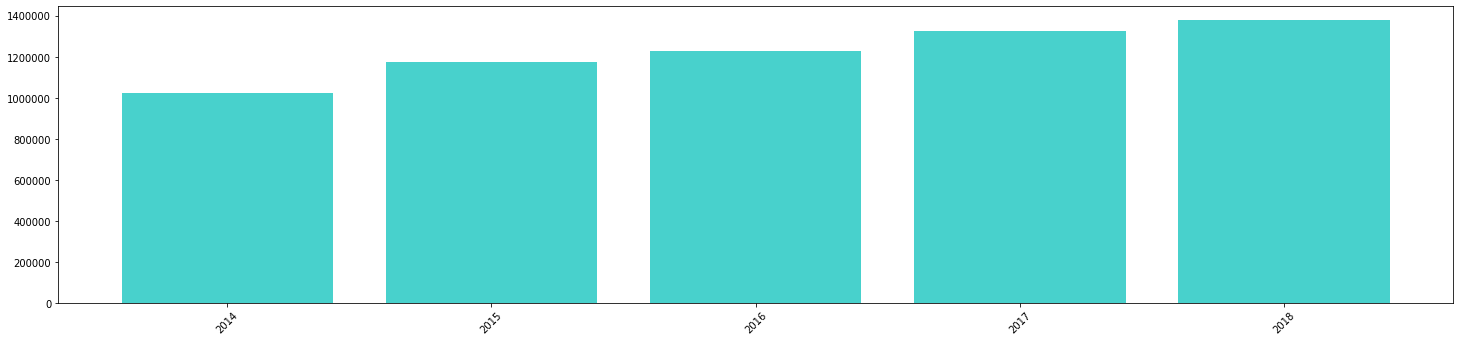

In [137]:
"""From the below plot we can see that number of sales grow each year coninously"""

barplot(sales_data, 'Year', 'sales')

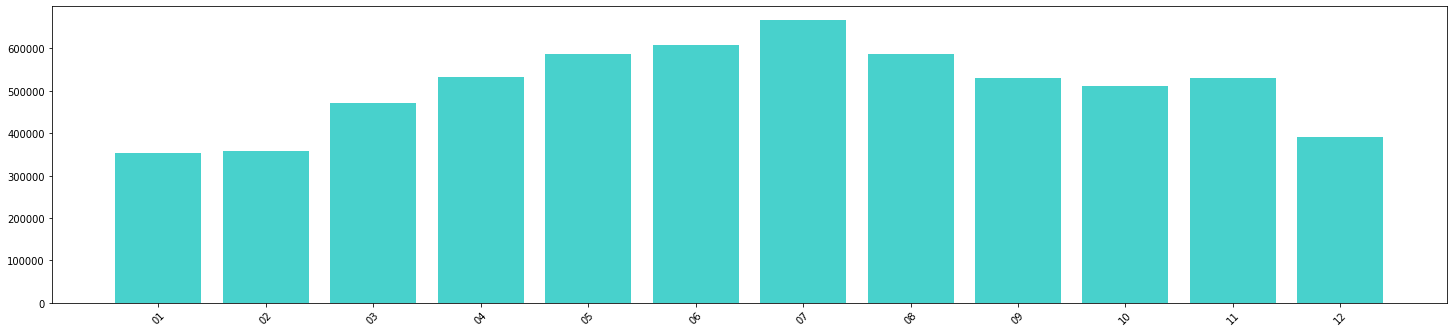

In [138]:
"""
Below plot shows the number of sales by each month. There are few pbservations which we ca infer from the below
1. We can see that number of sales are the least during the first couple of months and last month. There can be
few reasons like shop closed, vacation time etc
2. From this plot we can infer that sales continue to grow till JULY which is the seventh month and then drop down
Sales then increase again in November and then again drop in December
"""

barplot(sales_data, 'Month', 'sales')

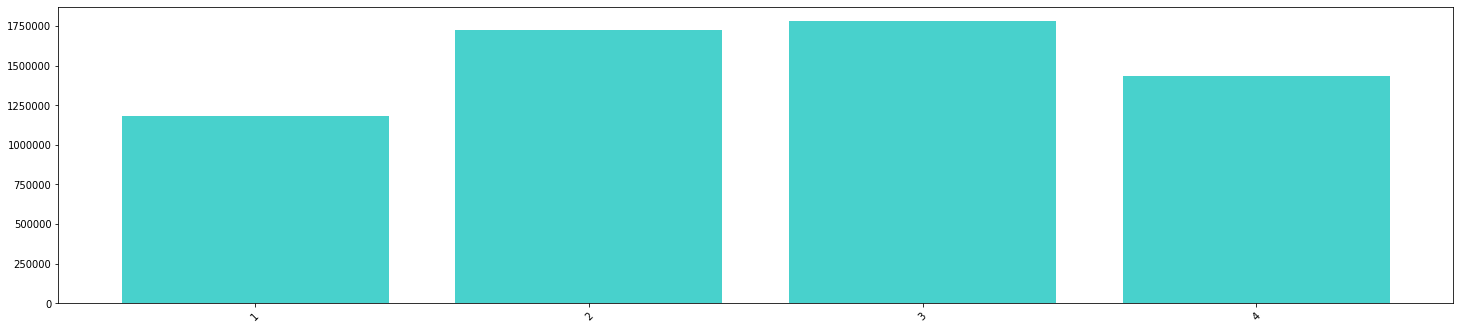

In [139]:
"""From the below plot we can again see that Quarter 2 and 3 has the most sales which we infered from the above plot
and First quarter has the least number of sales"""

barplot(sales_data, 'Quarter', 'sales')

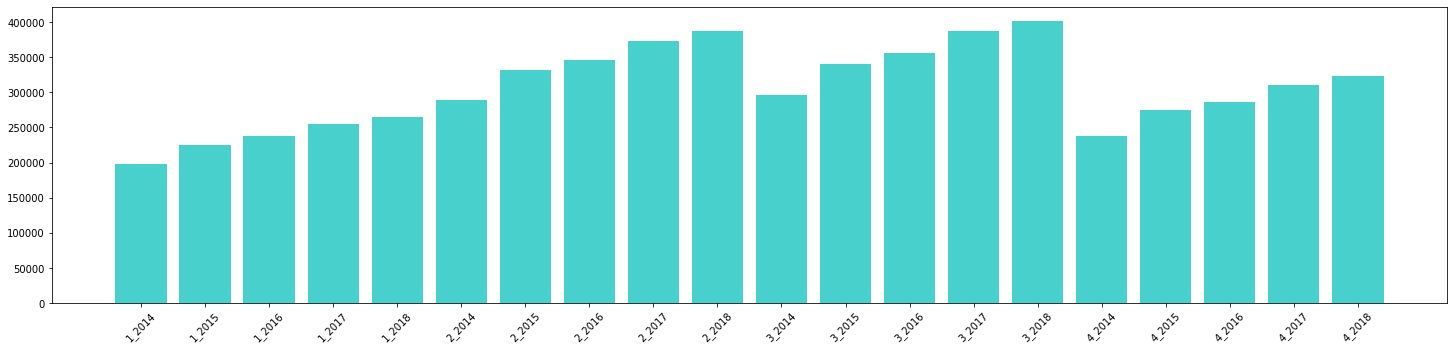

In [140]:
"""The below plot shows the quarter by quarter performance for each year. We can clearly say that there is improvement in 
every quarter and every year"""

barplot(sales_data, 'Quarter_By_Year', 'sales')

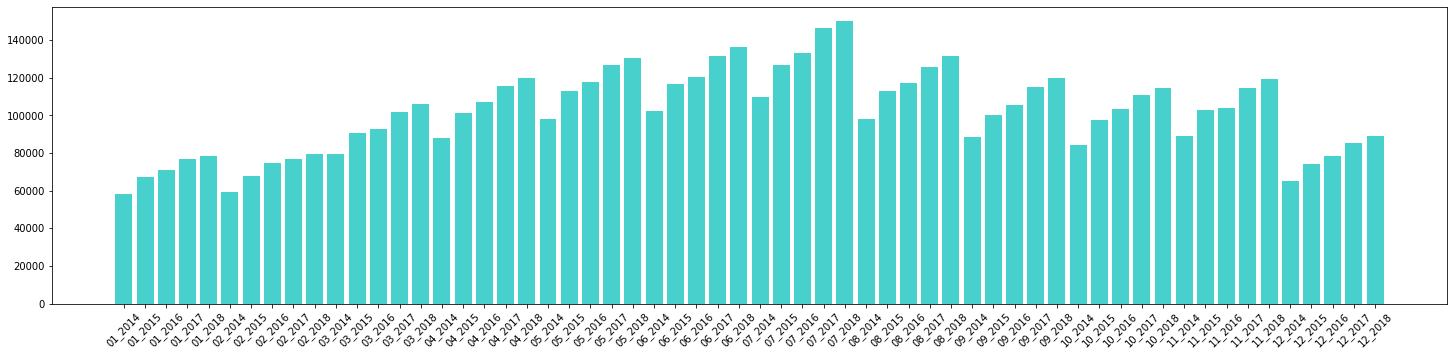

In [141]:
"""Below plot shows that every month has improvement in the number of sales for every year"""

barplot(sales_data, 'Month_By_Year', 'sales')

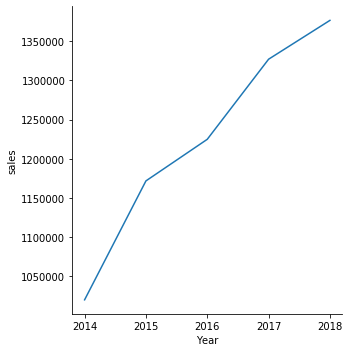

In [81]:
"""Below is the line chart showing the same thing that sales increase with year"""

sales_data_year  = sales_data.groupby(['Year'], as_index=False)['sales'].sum()
sns.relplot(x='Year', y ='sales', kind='line', data=sales_data_year)

### Conclusion

##### Based on the plots above we can say that there is an increase in the numbers of sales every year which is a good thing if we are planning to acquire of make any deal with the store. Few things which we can see are the increase in sales till mid year and then drop in the sales after ##### that . Management can make changes accordingly so that we can increase the sales till the end of year or try to find out the reason for drop in sales mid year

<p>

#### PROBLEM 1.2: Forecast 2018 Sales
At Rewards Network we deal with a lot of timeseries data both financial and behaivor. A classic time-series problem is forecasting. We'd like you to generate a forecast of 2019 daily sales for this store.

- Be sure to explain or demonstrate:
    - How you approach training, validation, testing, and prediction.
    - How you visualize your results
    - and How you assess model performance
- Export your final predictions to a csv file titled 'salesforecast_{yourname}.csv'
- Save you model to a pickly so we can quickly re-load the learned parameters

<p>

### CHALLENGE 2: Restaurant Classification
The following link points to a open source data set provided by the City of Chicago that tracks restaurant inspection outcomes since 2010:

https://data.cityofchicago.org/Health-Human-Services/Restaurant/5udb-dr6f

#### Problem 2.1: Inspection Predictions
Failed inspections directly impact our business. They are strong predictors of client churn and may worsen our members' experience.

We'd like you to generate a model that will predict whether or not a Chicago restaurant will fail its next inspection.

[we want to respect your time; do not feel compelled to explore more than a few top candidate features, but please explain why you believe the chosen features were good candidates and the insights you draw from them]
 
- Be sure to explain or demonstrate:
    - How you decide to define the target variable for your model
    - How you approach training, validation, test, and prediction
    - What features you explore
    - How you assess your features and their impact on you predictions
    - How you assess model performance
- Export your final predictions to a csv file titled 'inspectionprediction_{yourname}.csv'
- Save you model to a pickle so we can quickly re-load the learned parameters

In [47]:
import os
import re
import nltk
import pickle
import string
import warnings
import operator
import uszipcode
import itertools
import textblob
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from textblob import TextBlob
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from uszipcode import SearchEngine
from collections import Counter
import statsmodels.discrete.discrete_model as sm
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, ensemble, tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures

In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [5]:
data = pd.read_csv(r'C:\Users\17163\Desktop\Reward_Network_Data_Challenge\data-science-coding-challenge\datasets\chicago_restaurant_inspections.csv')

In [22]:
"""Function Created to help in different situations"""

def check_missing(data):
    col_mv = {}
    for i in list(data.columns):
        null_val = data[i].isnull().sum()
        if null_val!=0:
            col_mv[i] =  int(null_val)
    if col_mv:
        return sorted(col_mv.items(), key=operator.itemgetter(1))
    else:
        print("No Null Values")
        
        
def convertInteger(data, column):
    for i in range(0, len(data[column])):
        try:
            data[column].iat[i] = int(data[column].iat[i])
        except:
            pass
    return data[column]


def getFirstElemList(data, column):
    violation_numbers = []
    for elem in data[column]:
        try:
            elem2 = [i.split('.') for i in elem]
            elem_number = [item[0] for item in elem2]
            violation_numbers.append(elem_number)
        except:
            violation_numbers.append(elem) 
    return violation_numbers

def detect_polarity(text):
    try:
        TextBlob(text).sentiment.polarity
    except:
        pass
    
# stopword = nltk.corpus.stopwords.words('english')
# ps = nltk.PorterStemmer()
def clean_text(data):
    try:
        text= ''.join([word.lower() for word in data if word not in string.punctuation])
        text= re.sub('[0-9]+', '', text)
        text_token = re.split('\W+', text)
        text = [word for word in text_token if word not in stopword]
        text = [ps.stem(word) for word in text]
        text = ' '.join(text)
        return text
    except:
        pass
    
    
def barplot_count(data, data_group_column, attribute):
    target  = data.groupby(data_group_column)[attribute].count()
    z = []
    for i in range(len(target)):
        z.append(i+1)

    plt.figure(figsize=(20,12))
    plt.subplot(211)
    plt.bar(z, list(target), align='center', color ='mediumturquoise')
    labels = target.index
    plt.yticks(fontsize=10)
    plt.xticks(z, labels, fontsize=10, rotation = 90)
    plt.show()

In [7]:
data['Results'].unique()

array(['Fail', 'Pass w/ Conditions', 'Pass', 'Not Ready', 'No Entry',
       'Out of Business', 'Business Not Located'], dtype=object)

In [8]:
### There is only One Facility Type, so we will remove this from the set of features.
data['Facility Type'].unique()

array(['Restaurant'], dtype=object)

In [9]:
### We will remove the data where Results are Out of Business, Business Not Located and Not Ready (Don't know what that means)
### If a restaurant is out of the business, then there is very less probability of that being our client. Same is the case
### with the Business Not Located.

data = data[~data['Results'].isin(['Not Ready', 'No Entry', 'Out of Business', 'Business Not Located'])]

In [10]:
"""As we can see from the following that Most of the missing values are in Violations which can be one of the important 
factors while predicting the result of an inspection. Apart from that there are missing values in AKA Name, Location,
Latitude and Longitude which we will not be using because we have zip code and state which we can use alternatively. We can
drop the null values from city as they are very few in number. Same is the case with Risk and inspection"""

check_missing(data)

[('Inspection Type', 1),
 ('Risk', 2),
 ('Zip', 13),
 ('State', 17),
 ('City', 52),
 ('Latitude', 149),
 ('Longitude', 149),
 ('Location', 149),
 ('AKA Name', 683),
 ('Violations', 14545)]

In [11]:
"""Here we will remove the missing values from the data and also we will change data types to deal with missing data"""

data = data[~data['AKA Name'].isnull()]
data = data[~data['Location'].isnull()]
data = data[~data['Risk'].isnull()]
data = data[~data['Inspection Type'].isnull()]
data = data[~data['Zip'].isnull()]

# data['City'] = data['City'].fillna('NA')
# data['State'] = data['State'].fillna('NA')
data['Zip'] = data['Zip'].astype(int)

In [12]:
"""Now we will make use of library from python to find the city based on the zipcode. This will help us in keeping the data
which will help us for training and testing purpose instead of removing"""

search = SearchEngine()
city = []
for i in range(0, len(data)):
    if pd.isnull(data['City'].iloc[i]):
        city.append(search.by_zipcode(data['Zip'].iloc[i]).major_city)
    else:
        city.append(data['City'].iloc[i])
    
state = []
for i in range(0, len(data)):
    if pd.isnull(data['State'].iloc[i]):
        state.append(search.by_zipcode(data['Zip'].iloc[i]).state)
    else:
        state.append(data['State'].iloc[i])

In [13]:
data['City']  = city
data['State'] = state

In [14]:
""" Now we have dealt with all the missing values apart from violations. Let's tackle this now"""

check_missing(data)

[('Violations', 14307)]

In [15]:
"""We can see that there are codes for violations at the very beginning. Let's use those instead of sentences for our analysis.
Also number of violation for both pass results and fail results are more than One. So we have to consider all of them while doing
analysis"""

data['Violations_New'] = data['Violations'].str.split('|') 
data['Violations_New'] = getFirstElemList(data, 'Violations_New')
data['Violations_New'] = data['Violations_New'].fillna('NA')
data['Violation_Length'] = data['Violations_New'].apply(len) ## To see if number of violations has any effect on result

In [16]:
"""Just keeping two categories at the moment. Converting pass with consditions to pass as well"""
data['Results'] = ['Pass' if 'Pass' in i else 'Fail' for i in data['Results']]

In [17]:
"""Now I want to see if there are any Violation Number which are overlapping in both pass and fail category. If they are not 
then we will just label the violations as bad and good to avoid the complications in the analysis.
From the below number we can clearly see that number of violations for the restaurant which Failed Inspection has twice the 
violations as which passed. So we will include this feature into the model"""

pass_data = data[data['Results'] == 'Pass']
pass_data = pass_data.dropna()
fail_data = data[data['Results'] == 'Fail']
fail_data = fail_data.dropna()
print("Average number of violation where restaurant passed the inspection is " + str(pass_data['Violation_Length'].mean()) )
print("Average number of violation where restaurant passed the inspection is " + str(fail_data['Violation_Length'].mean()) )

Average number of violation where restaurant passed the inspection is 3.9801307847082494
Average number of violation where restaurant passed the inspection is 6.768634810644339


In [18]:
"""In this step i am checking if there are any specific violations which are causing the passing and failure of inspection.
But eventually it seems confusing as the violations are common in both the cases. So we will use something else for features"""

violations_pass = list(pass_data['Violations_New'])
violations_pass = list(itertools.chain.from_iterable(violations_pass))
violations_pass_set = set(violations_pass)
Number_of_violation_pass = Counter(violations_pass)
Number_of_violation_pass = {k: v for k, v in sorted(Number_of_violation_pass.items(), key=lambda item: item[1], reverse=True)}

violations_fail = list(fail_data['Violations_New'])
violations_fail = list(itertools.chain.from_iterable(violations_fail))
violations_fail_set = set(violations_pass)
Number_of_violation_fail = Counter(violations_fail)
Number_of_violation_fail = {k: v for k, v in sorted(Number_of_violation_fail.items(), key=lambda item: item[1], reverse=True)}

In [19]:
Number_of_violation_pass

{' 34': 27211,
 ' 35': 25342,
 ' 38': 22075,
 ' 33': 20578,
 '32': 15683,
 ' 41': 13179,
 ' 36': 11101,
 ' 32': 11000,
 '33': 10862,
 ' 55': 8512,
 '3': 7919,
 '30': 7142,
 ' 40': 6995,
 ' 5': 5441,
 '34': 5374,
 ' 43': 5221,
 ' 58': 5052,
 ' 45': 4811,
 ' 37': 4198,
 ' 47': 3922,
 ' 42': 3528,
 ' 51': 3085,
 '31': 2885,
 ' 56': 2795,
 ' 23': 2758,
 '21': 2724,
 '35': 2631,
 ' 49': 2613,
 ' 31': 2538,
 '2': 2402,
 ' 3': 2237,
 '38': 2182,
 ' 57': 2161,
 ' 25': 2130,
 ' 30': 2106,
 ' 10': 1998,
 ' 53': 1298,
 ' 39': 1241,
 ' 21': 1148,
 '5': 913,
 ' 16': 883,
 '16': 859,
 '36': 808,
 ' 44': 786,
 '8': 699,
 '10': 657,
 '6': 624,
 '41': 614,
 ' 22': 571,
 ' 48': 538,
 '1': 477,
 '14': 473,
 '37': 460,
 '12': 442,
 ' 28': 402,
 ' 8': 383,
 ' 29': 363,
 '47': 354,
 ' 60': 350,
 '40': 349,
 '11': 347,
 ' 12': 346,
 '55': 337,
 '45': 335,
 ' 2': 277,
 ' 6': 275,
 '28': 261,
 '25': 255,
 '49': 247,
 '23': 239,
 ' 54': 233,
 '29': 212,
 ' 11': 208,
 '51': 206,
 ' 61': 157,
 '9': 157,
 ' 9': 15

In [20]:
Number_of_violation_fail

{' 34': 11138,
 ' 33': 10527,
 ' 38': 10445,
 ' 35': 10337,
 ' 32': 9124,
 ' 41': 5918,
 ' 36': 5149,
 '18': 5013,
 ' 18': 4002,
 ' 55': 3952,
 ' 30': 3082,
 '3': 3021,
 ' 40': 3019,
 ' 29': 2675,
 '2': 2303,
 ' 21': 2153,
 ' 37': 2025,
 ' 43': 2013,
 ' 31': 1954,
 ' 5': 1936,
 ' 16': 1804,
 ' 47': 1784,
 ' 45': 1764,
 ' 10': 1686,
 ' 58': 1681,
 '16': 1680,
 ' 3': 1662,
 ' 49': 1428,
 ' 19': 1420,
 ' 51': 1419,
 '29': 1304,
 ' 42': 1277,
 ' 56': 1223,
 ' 24': 1155,
 '11': 1101,
 ' 57': 1049,
 ' 23': 1031,
 ' 22': 980,
 ' 25': 894,
 ' 48': 839,
 ' 39': 724,
 '19': 708,
 ' 53': 678,
 ' 12': 622,
 '8': 609,
 ' 60': 582,
 ' 11': 582,
 '24': 542,
 '12': 485,
 '10': 479,
 ' 54': 458,
 ' 28': 451,
 '1': 438,
 '6': 436,
 ' 8': 435,
 '14': 375,
 ' 44': 359,
 '9': 354,
 '21': 331,
 ' 9': 300,
 ' 26': 284,
 '5': 256,
 ' 2': 251,
 ' 6': 236,
 '22': 226,
 ' 70': 188,
 ' 59': 165,
 ' 13': 162,
 ' 52': 151,
 '38': 145,
 '26': 145,
 '13': 142,
 ' 14': 135,
 ' 50': 129,
 '32': 123,
 ' 61': 93,
 '4': 7

In [21]:
"""From the above two dictionaries we can see that it's very confusing to find which violation is actually responsible for
Failing or Passing the Inspection Test. To tackle this problem let's use sentiment analysis on the Violations. I will not be
going into much detail. I won't be building a sentiment analysis model from scratch instead i will be using Textblob
This step will take time as there is lot of processing happening and cleaning of comments happening. But we can improve that
later by improving the efficacy of code"""

text = []
for i in data['Violations']:
    try:
        text.append(clean_text(i))
    except:
        text.append(i)

data['Violations'] = text

polarity = []
for i in data['Violations']:
    try:
        polarity.append(TextBlob(i).sentiment.polarity)
    except:
        polarity.append(i)

data['Polarity'] = polarity

In [23]:
data['Year'] = pd.to_datetime(data['Inspection Date']).dt.year

In [24]:
check_missing(data)

[('Violations', 14307), ('Polarity', 14307)]

In [25]:
"""We can see that there is difference in the polarity score but it doesn't look too much. But still we will consider that as
a feature"""

pass_data_polarity = data[data['Results'] == 'Pass']
fail_data_polarity = data[data['Results'] == 'Fail']
print("Average Polarity Score for Pass is "  + str(pass_data_polarity['Polarity'].mean()))
print("Average Polarity Score for Fail is "  + str(fail_data_polarity['Polarity'].mean()))

Average Polarity Score for Pass is 0.2529923825393548
Average Polarity Score for Fail is 0.19316259327575988


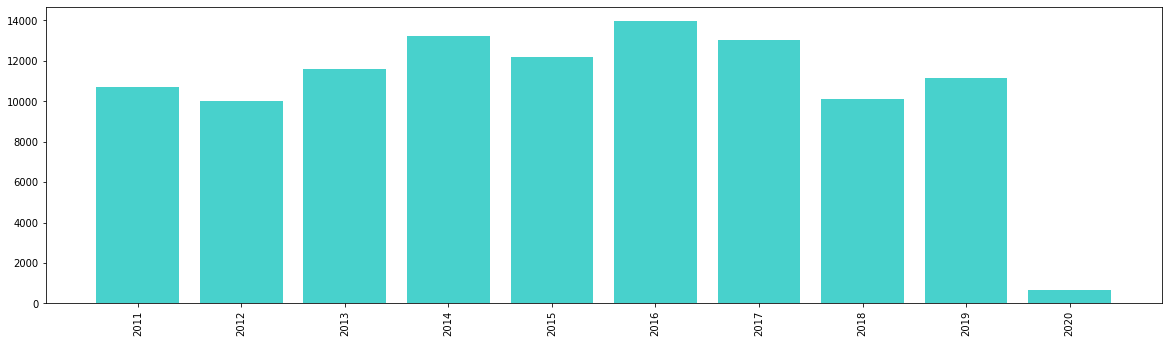

In [26]:
"""This is showing us the Number of inxpections per year"""
barplot_count(data, 'Year', 'Results')

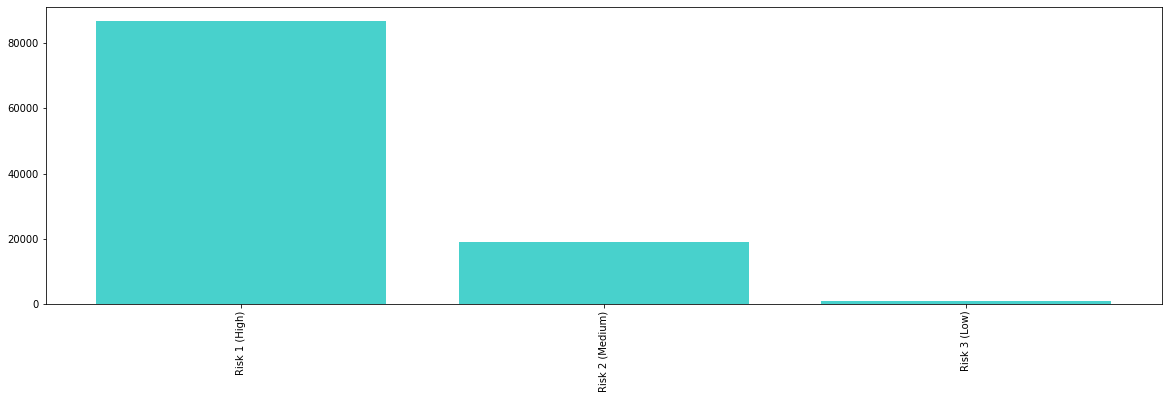

In [27]:
barplot_count(data, 'Risk', 'Results')

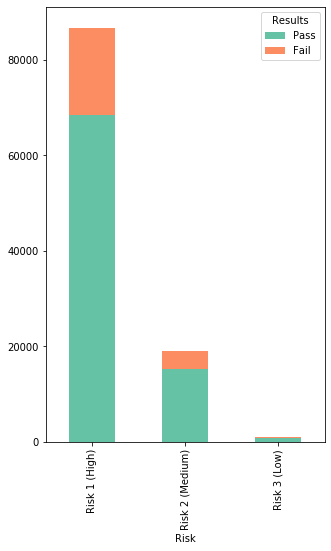

In [28]:
pal = sns.color_palette("Set2")
data_groupby = data.groupby(['Risk', 'Results'])['Results'].count().unstack('Results').fillna(0)
data_groupby[['Pass','Fail']].plot(kind='bar', stacked=True, color=pal, figsize=(5, 8))

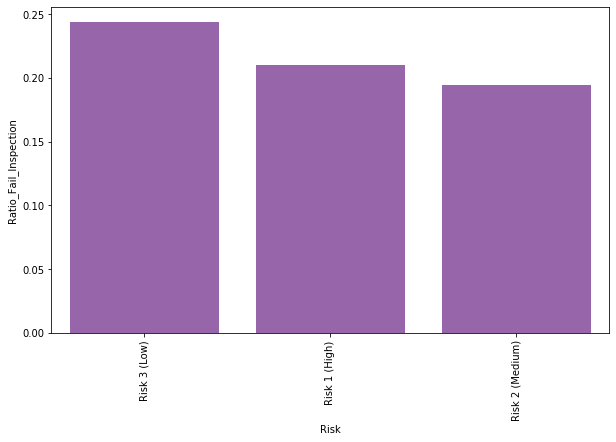

In [29]:
"""From the below plot it is clear that i"""

data_groupby['Ratio_Fail_Inspection'] = data_groupby['Fail'] / (data_groupby['Fail'] + data_groupby['Pass']) 
data_groupby = data_groupby.sort_values('Ratio_Fail_Inspection', ascending=False)

plt.figure(figsize=(10,6))
plt.xticks(fontsize=10, rotation = 90)
sns.barplot(data_groupby.index, data_groupby['Ratio_Fail_Inspection'], color ='#9b59b6')

<Figure size 1080x504 with 0 Axes>

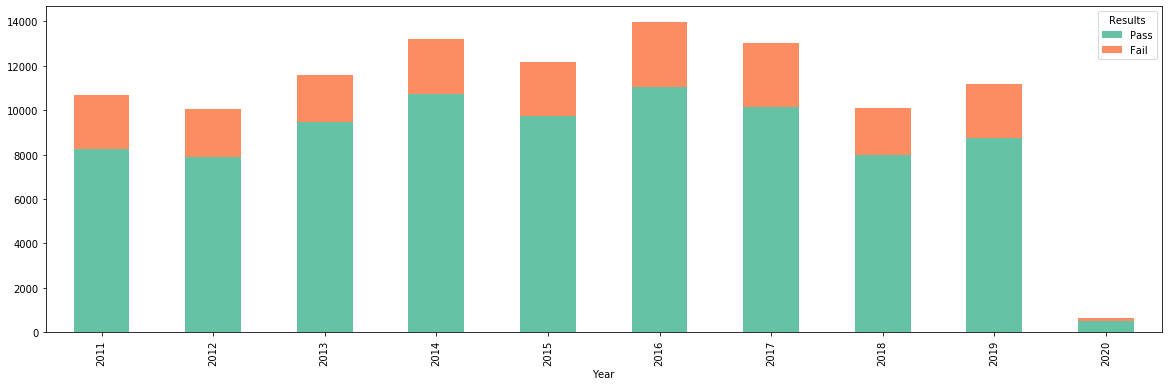

In [30]:
"""From the below plot we can see the number of pass and fail inspections per year and it is clear that there is imabalnce in
data. Data with Failed inspection are 1/4 times the pass inspections."""

plt.figure(figsize=(15, 7))
pal = sns.color_palette("Set2")
data_groupby = data.groupby(['Year', 'Results'])['Results'].count().unstack('Results').fillna(0)
data_groupby[['Pass','Fail']].plot(kind='bar', stacked=True, color=pal, figsize=(20, 6))

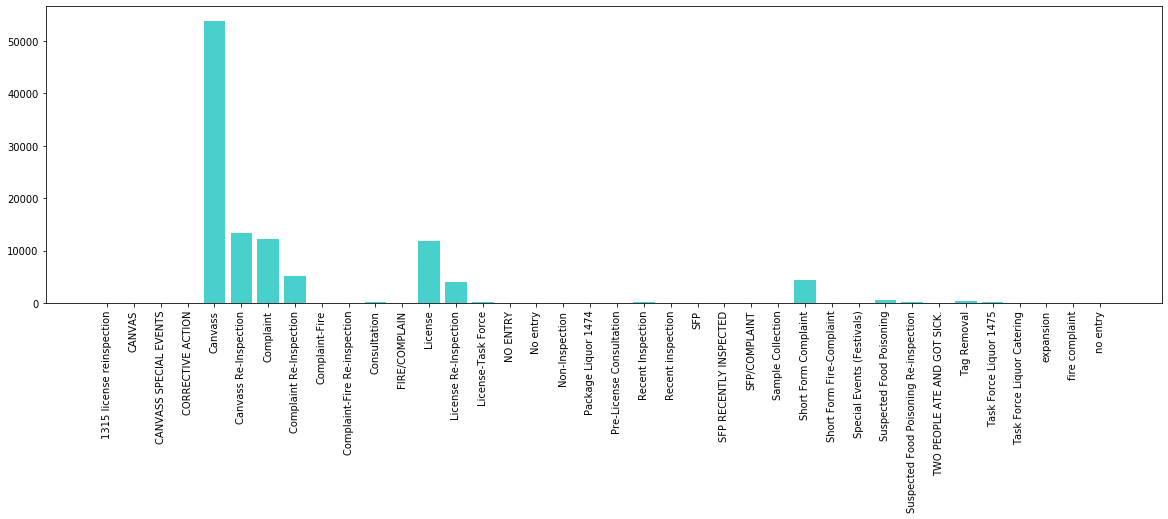

In [31]:
"""From the below plot what we can see the various Inspection Type for the data. We can infer that most of the inspections
were of type Canvas which is almost 50% this will cause imbalance or bias because of the feature so we need to pre process this
by combining various Inspection Type. At the moment i will keep it like that. Because i need to understand what each 
Inspection Type means and that i get to know from buisness people only"""

barplot_count(data, 'Inspection Type', 'Results')

In [32]:
"""As we can see that there is only one city and State in the data. So we won't be including this as a feature"""

print(data['City'].unique())
print(data['State'].unique())

['CHICAGO' 'Chicago' 'chicago' 'CHICAGOCHICAGO' 'CCHICAGO' 'CHICAGO.'
 'CHICAGOHICAGO' 'CHICAGOI' '312CHICAGO']
['IL']


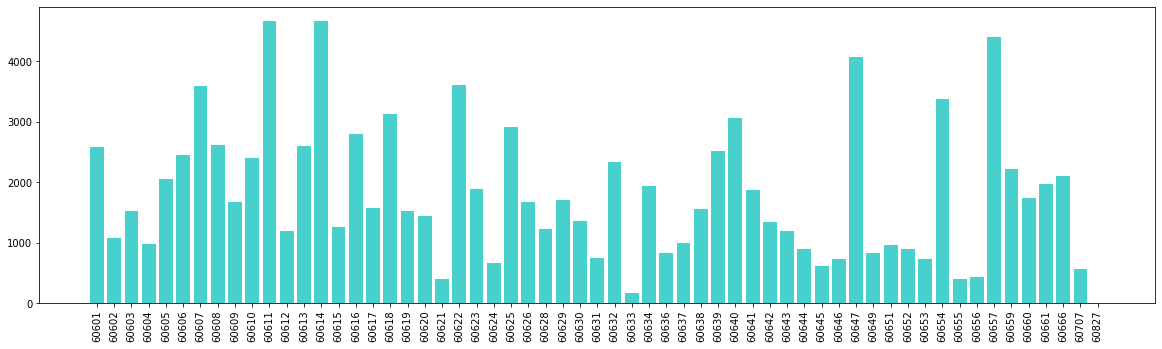

In [33]:
"""From the bar chart below we can clearly see that number of inspections varies by zipcode and that may be because some
zipcodes have more restaurants than other."""
barplot_count(data, 'Zip', 'Results')

<Figure size 1080x504 with 0 Axes>

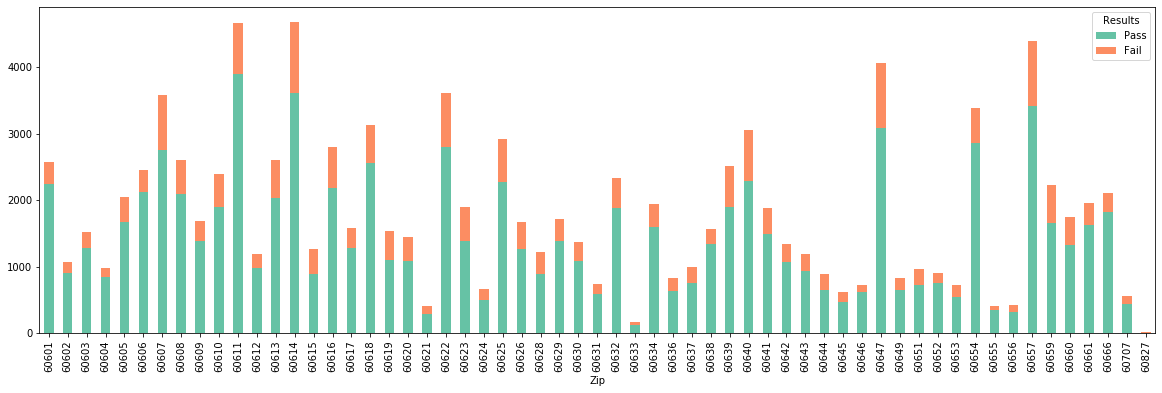

In [34]:
"""Following plot shows us the """

plt.figure(figsize=(15, 7))
pal = sns.color_palette("Set2")
data_groupby = data.groupby(['Zip', 'Results'])['Results'].count().unstack('Results').fillna(0)
data_groupby[['Pass','Fail']].plot(kind='bar', stacked=True, color=pal, figsize=(20, 6))

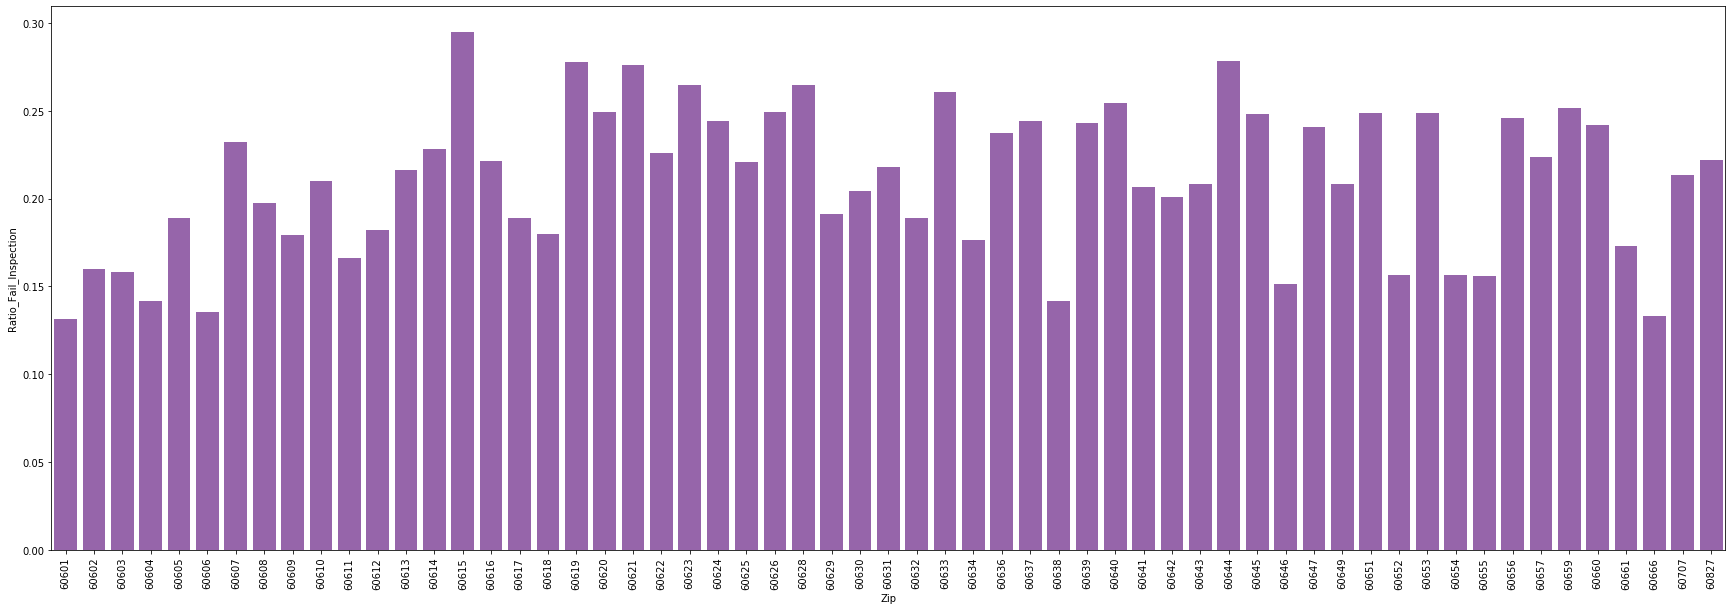

In [35]:
"""Following plot shows the zipcode with ratio of failing inspection. Based on the plot 60601 and 60606 has the lease ratio
which means most of restaurants passed the inspection"""

data_groupby['Ratio_Fail_Inspection'] = data_groupby['Fail'] / (data_groupby['Fail'] + data_groupby['Pass']) 
data_groupby = data_groupby.sort_values('Ratio_Fail_Inspection', ascending=False)

plt.figure(figsize=(30, 10))
plt.xticks(fontsize=10, rotation = 90)
sns.barplot(data_groupby.index, data_groupby['Ratio_Fail_Inspection'], color ='#9b59b6')

In [36]:
data_features = data[['License #', 'Risk', 'Zip', 'Inspection Type', 'Violation_Length', 'Polarity', 'Results']]

In [37]:
### From this we can see that restaurant can have more than one inspection as well
### So we need to preprocess based on the features and avoid duplicates from data
data_features[data_features['License #'] == 34199]

,License #,Risk,Zip,Inspection Type,Violation_Length,Polarity,Results
1,34199,Risk 1 (High),60666,Canvass,11,0.252941,Fail
2977,34199,Risk 1 (High),60666,Canvass,5,0.100198,Pass
12801,34199,Risk 1 (High),60666,Canvass,5,0.352066,Fail
29248,34199,Risk 1 (High),60666,Canvass,3,0.276190,Pass
30951,34199,Risk 1 (High),60666,Canvass,4,0.083696,Pass
33303,34199,Risk 1 (High),60666,Canvass,2,0.419048,Pass
34883,34199,Risk 1 (High),60666,Tag Removal,2,NaN,Pass
35185,34199,Risk 1 (High),60666,Canvass Re-Inspection,3,0.215000,Pass
35919,34199,Risk 1 (High),60666,Canvass,4,0.430303,Pass
37804,34199,Risk 1 (High),60666,Canvass,6,0.328571,Pass


In [38]:
data_features = data_features.drop_duplicates()
data_features = data_features.drop('License #', axis = 1)
data_features['Results'] = [1 if i == 'Pass' else 0 for i in data_features['Results']]

In [39]:
len(data_features)

104741

In [41]:
"""We will be doing encoding in this cell. I am doing Label Encoding and Deviation encoding. There are advantages of these
like dimensionality of data is not increase. Also target encoding is directly related to output which can have good impact
on the model. We will use these to start with but we can use dummies if the output is not correct"""

labelencoder_store_type = LabelEncoder()
data_features['Risk']  = labelencoder_store_type.fit_transform(data_features['Risk'])

means_zip_target  = data_features.groupby('Zip')['Results'].mean()
means_inspection_target = data_features.groupby('Inspection Type')['Results'].mean()

dict_zip_target   = dict(zip(means_zip_target.index, means_zip_target.values))
dict_inspection_target  = dict(zip(means_inspection_target.index, means_inspection_target.values))

data_features['Zip'] = data_features['Zip'].map(dict_zip_target)
data_features['Inspection Type']   = data_features['Inspection Type'].map(dict_inspection_target)


In [42]:
""" We will handle the missing value by doing the imputation and for that purpose I will be filling with the mean values 
Standardizing the numerical data using sklearn. 
Every Feature has different range. Therefore they are normalized so that every feature has equal importance at the beginning"""

data_cat     = data_features.drop('Violation_Length', axis=1)
data_noncat  = data_features[['Violation_Length']]

min_max      = MinMaxScaler()
columns_test = list(data_noncat.columns)
data_noncat  = min_max.fit_transform(data_noncat[list(data_noncat.columns)])
data_noncat  = pd.DataFrame(data_noncat, columns=columns_test)
data_features['Violation_Length'] = data_noncat['Violation_Length']
data_features['Violation_Length'] = data_features['Violation_Length'].fillna(data_features['Violation_Length'].mean())
data_features['Polarity'] = data_features['Polarity'].fillna(data_features['Polarity'].mean())

In [43]:
"""As we can see from the results that there is a imbalance between the classes. But let's start with building a model for the
imabalanced dataset and see how it performs and then we will perform SMOTE to deal with imbalance"""

data_features['Results'].value_counts()

1    82644
0    22097
Name: Results, dtype: int64

In [44]:
Independant = data_features.drop(['Results'],axis=1)
Dependant = data_features["Results"]
X_train, X_test, Y_train, Y_test = train_test_split(Independant, Dependant, test_size = 0.3, random_state = 0)

In [45]:
Y_train.value_counts()

1    57917
0    15401
Name: Results, dtype: int64

In [49]:
"""Because it is a binary problem, i will start with Logistic regression to built the model.
Based on the output we can see that Polarity, Zip and Inspection type has impact on the outcome which is evident. Also all the features
has p-value less than 0.05 which acan show that they are somewhat useful"""

logit_model=sm.Logit(Y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.484461
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.058     
Dependent Variable: Results          AIC:              71049.3525
Date:               2020-02-08 18:03 BIC:              71095.3654
No. Observations:   73318            Log-Likelihood:   -35520.   
Df Model:           4                LL-Null:          -37688.   
Df Residuals:       73313            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Risk              0.0642   0.0224   2.8673 0.0041  0.0203  0.1081
Zip              -3.3243   0.0948 -35.0768 0.0000 -3.5101 -3.1386


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.78


In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)

[[  328  6368]
 [  486 24241]]


In [53]:
y_pred

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [54]:
test = pd.DataFrame({'Predicted' : y_pred, 'Results': Y_test})
test.to_csv('C:/Users/17163/Desktop/inspectionprediction_VikramLR.csv', index = False)

In [55]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.05      0.09      6696
           1       0.79      0.98      0.88     24727

    accuracy                           0.78     31423
   macro avg       0.60      0.51      0.48     31423
weighted avg       0.71      0.78      0.71     31423



In [56]:
"""Now we will use SMOTE to deal with the imbalance. I am having some issues with installing that package. 
So i will leave it here itself. But the process is creating minority samples and perform logistic regression on that"""

# from imblearn.over_sampling import SMOTE
# os = SMOTE(random_state=0)
# columns = X_train.columns
# os_data_X,os_data_y=os.fit_sample(X_train, Y_train)
# os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
# os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

'Now we will use SMOTE to deal with the imbalance. I am having some issues with installing that package. \nSo i will leave it here itself. But the process is creating minority samples and perform logistic regression on that'

In [57]:
"""Now We will do the hyperparameter tuning for the model using GridSearchCv. I will just select the parameters randomlyn5
"""

rfc=RandomForestClassifier(random_state=42)

param_grid = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, Y_train)

CV_rfc.best_params_


# {'criterion': 'gini',
#  'max_depth': 7,
#  'max_features': 'auto',
#  'n_estimators': 200}

In [58]:
"""From the above we can clearly see the parameters which provide us the best results. Lets use them now"""

model = RandomForestClassifier(max_depth=7, max_features='auto', criterion='gini', n_estimators=200)
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
predictions = model.predict(X_test)

In [60]:
test = pd.DataFrame({'Predicted' : predictions, 'Results': Y_test})
test.to_csv('C:/Users/17163/Desktop/inspectionprediction_VikramRF.csv', index = False)

In [61]:
"""But we are not interested in the accuracy we are interested in precision and recall as the data is imbalance"""

print("Accuracy for Random Forest on CV data: ",accuracy_score(Y_test,predictions))

Accuracy for Random Forest on CV data:  0.7920313146421412


In [62]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.07      0.13      6696
           1       0.80      0.99      0.88     24727

    accuracy                           0.79     31423
   macro avg       0.70      0.53      0.50     31423
weighted avg       0.76      0.79      0.72     31423



In [63]:
"""We can see that results are not as good as logisic regression. This may be because of the hyperparameters we selected"""

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, predictions)
print(confusion_matrix)

[[  476  6220]
 [  315 24412]]


In [64]:
""" From the below feature importances we can see that Polarity, Inspection Type and Risk are the most important features which was the
case with Logistic regression as well"""

dict(zip(X_train.columns, model.feature_importances_))

{'Risk': 0.004334906513600255,
 'Zip': 0.07036520270110738,
 'Inspection Type': 0.32035656745165886,
 'Violation_Length': 0.012541951082573943,
 'Polarity': 0.5924013722510596}

In [65]:
from sklearn.externals import joblib 
joblib.dump(logreg,'C:/Users/17163/Desktop/Logistic_Regression_Problem_Second.pkl')
joblib.dump(model,'C:/Users/17163/Desktop/Random_Forest_Problem_Second.pkl')

['C:/Users/17163/Desktop/Random_Forest_Problem_Second.pkl']

### I will stop  my analysis for this problem here and answer the questions asked.

#### 1. In this case our target variable is Results of the inspection. What we want to know is whether the restaurant passed inspection or not.
#### 2. In this case what i have done is split of train and test on the data after prep. I didn't use validation data as i was not planning on using K-Fold cross validation. I kept my model simple and end up splitting into two parts. But one thing which i can use as my test data is the data i filtered out initially based on the results. I can use that as my test and compare the outcomes of that with the real ones

#### 3. I explained about the features i used and why i used them also the importance of those features in the above steps.

#### 4. At the moment my model is not performing as i was not able to perform smote. Out of the two models i used, I can say Random Forest performed better but still there is lot to be done to improve the output. Also I explained all the metrics i used in the above steps


<p>

### CHALLENGE 3: Market Clustering
The 'food_environement_atlas.xls' excel file in the datasets directory contains a wide variety of food availability metrics across counties (counties are uniquely identified by a FIPS is). Full documentation on all the terms can be found here:

https://www.ers.usda.gov/data-products/food-environment-atlas/documentation

#### Problem 3.1: Characterizing Markets
At Rewards Network, our mission is to partner in the growth of local restaurants. To do this we need to understand the market context within which each restaurant is situated.

Treating each county as its own market, we'd like you to identify a set of market clusters that can help us categorize our clients market environement and potentially inform our strategy to help them grow.

[Again, don't feel compelled to use all the data; Efficiency is a virtue; Try to assess which data will likely be informative to the challenge]
 
- Be sure to explain or demonstrate:
    - Why you chose the data selected for clustering
    - How you pre-process the data
    - How you choose an appropriate clustering algorihtm
    - Why you determine the number of clusters
    - How you assess model performance
    - How you can characterize your clusters in terms or metrics that would be salient to a Marketer or Sales-Rep
- Export your final predictions to a csv file titled 'marketclusters_{yourname}.csv'
- Save you model to a pickle so we can quickly re-load the learned parameters

<p>